# Instalasi Package

In [1]:
!pip install tensorflow scikit-learn

# Import Library

In [3]:
# Standard Library
import os
import shutil
import random
import zipfile

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from PIL import Image
import cv2

# Machine Learning & Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Google Colab
from google.colab import files

# Mount Google Drive dan Ekstrak Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_file_path = '/content/drive/MyDrive/tumor_otak_dataset.zip'

extract_path = '/content/brain_tumor/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

for root, dirs, files in os.walk(extract_path):
    for name in files:
        print(os.path.join(root, name))

/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_1273.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_1153.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_0413.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_1217.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_0347.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_0286.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_0877.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_0080.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_0067.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_1227.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_0629.jpg
/content/brain_tumor/tumor_otak_dataset/dataset_2/Training/glioma/Tr-gl_0112.jpg
/content/brain_tumor/tumor_o

# Menggabungkan Dataset

In [7]:
dataset_paths = [
    '/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing',
    '/content/brain_tumor/tumor_otak_dataset/dataset_1/Training',
    '/content/brain_tumor/tumor_otak_dataset/dataset_2/Testing',
    '/content/brain_tumor/tumor_otak_dataset/dataset_2/Training',
]

In [8]:
combined_dir = '/content/brain_tumor/tumor_otak_dataset/combined'

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
for cls in classes:
    os.makedirs(os.path.join(combined_dir, cls), exist_ok=True)

for path in dataset_paths:
    for cls in classes:
        src_dir = os.path.join(path, cls)
        dst_dir = os.path.join(combined_dir, cls)
        if os.path.exists(src_dir):
            for fname in os.listdir(src_dir):
                src_file = os.path.join(src_dir, fname)
                dst_file = os.path.join(dst_dir, fname)
                shutil.copy2(src_file, dst_file)

# Visualisasi Sampel Gambar

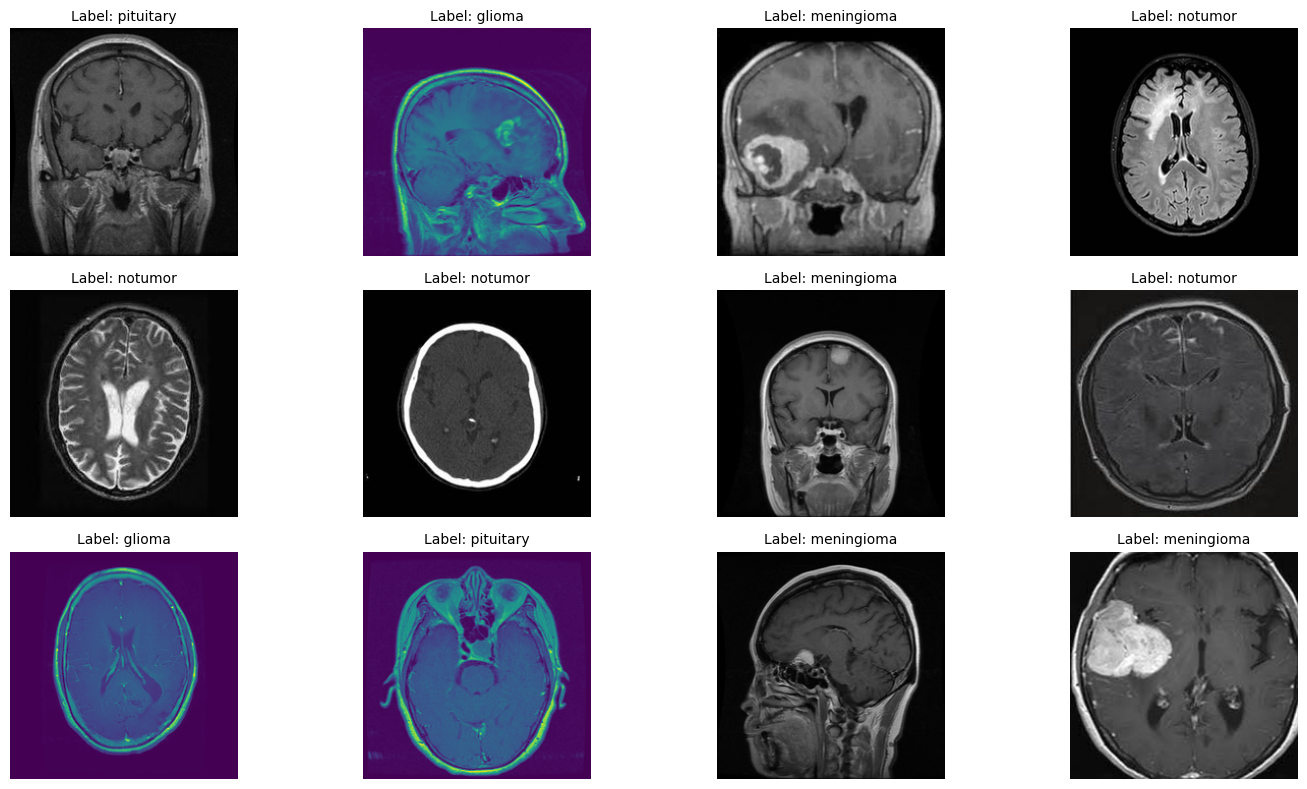

In [9]:
combined_dir = '/content/brain_tumor/tumor_otak_dataset/combined'

combined_paths = []
combined_labels = []

for path, subdirs, files in os.walk(combined_dir):
    for name in files:
        combined_paths.append(os.path.join(path, name))
        combined_labels.append(os.path.basename(path))

random_choice = random.sample(range(len(combined_paths)), 12)

fig, axes = plt.subplots(3, 4, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_choice):
    img_path = combined_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {combined_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

# Statistik Dataset

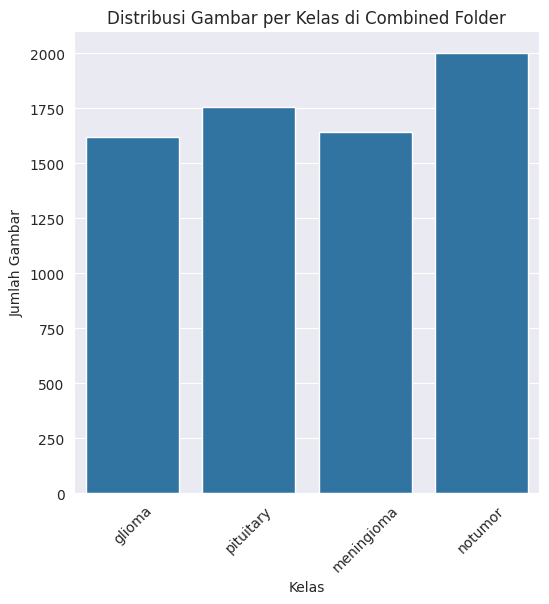

In [10]:
distribution_df = pd.DataFrame({'path': combined_paths, 'label': combined_labels})

plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x="label")
plt.title("Distribusi Gambar per Kelas di Combined Folder")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

In [11]:
distribution_df = pd.DataFrame({'path': combined_paths, 'label': combined_labels})

class_counts = distribution_df['label'].value_counts()
print("Jumlah data per kelas di folder Combined:")
print(class_counts)

Jumlah data per kelas di folder Combined:
label
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


# **Split Dataset** - Train, Validation, Test




In [12]:
combined_dir = '/content/brain_tumor/tumor_otak_dataset/combined'

split_dataset_dir = "/content/brain_tumor/split"
train_dir = os.path.join(split_dataset_dir, "train")
val_dir = os.path.join(split_dataset_dir, "val")
test_dir = os.path.join(split_dataset_dir, "test")

for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

val_ratio = 0.2
test_ratio = 0.1

for class_name in os.listdir(combined_dir):
    class_path = os.path.join(combined_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    train_val_files, test_files = train_test_split(files, test_size=test_ratio, random_state=42)

    val_size_adjusted = val_ratio / (1 - test_ratio)  # 0.2 / 0.9
    train_files, val_files = train_test_split(train_val_files, test_size=val_size_adjusted, random_state=42)

    def salin(files, destination_dir):
        os.makedirs(os.path.join(destination_dir, class_name), exist_ok=True)
        for file in files:
            src = os.path.join(class_path, file)
            dst = os.path.join(destination_dir, class_name, file)
            shutil.copy2(src, dst)

    salin(train_files, train_dir)
    salin(val_files, val_dir)
    salin(test_files, test_dir)

print("Dataset berhasil dibagi: 70% train, 20% validation, 10% test.")

for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dataset_dir, split)
    print(f"\n{split.upper()} SET:")
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        num_images = len(os.listdir(class_path))
        print(f"- {class_name}: {num_images} images")

Dataset berhasil dibagi: 70% train, 20% validation, 10% test.

TRAIN SET:
- glioma: 1134 images
- pituitary: 1229 images
- meningioma: 1151 images
- notumor: 1400 images

VAL SET:
- glioma: 324 images
- pituitary: 352 images
- meningioma: 329 images
- notumor: 400 images

TEST SET:
- glioma: 163 images
- pituitary: 176 images
- meningioma: 165 images
- notumor: 200 images


# Visualisasi Distribusi Data per Split

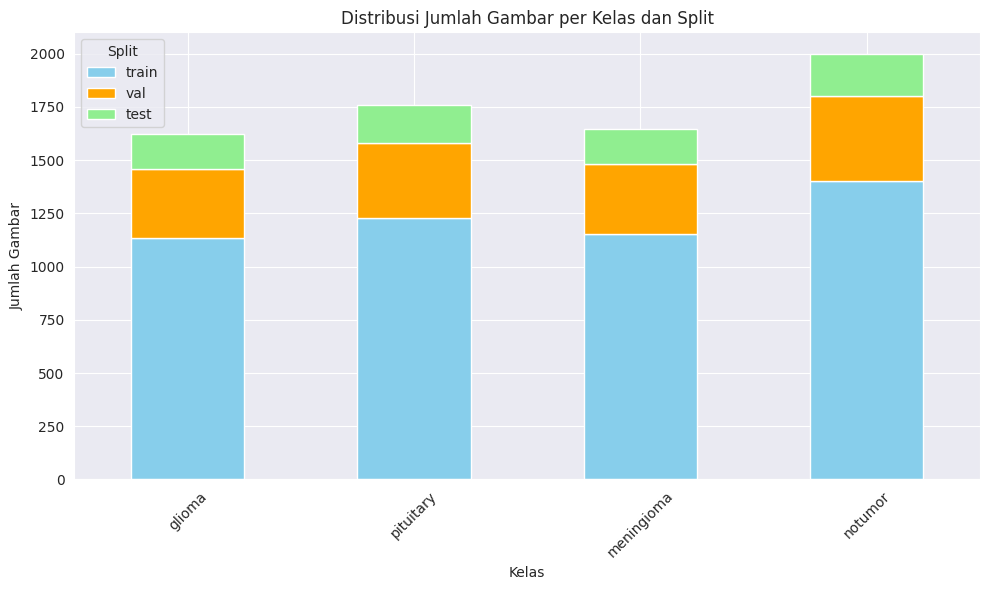

In [13]:
split_counts = {'train': [], 'val': [], 'test': []}
classes = os.listdir(train_dir)

for split in ['train', 'val', 'test']:
    for class_name in classes:
        path = os.path.join(split_dataset_dir, split, class_name)
        count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        split_counts[split].append(count)

df = pd.DataFrame(split_counts, index=classes)

df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange', 'lightgreen'])
plt.title('Distribusi Jumlah Gambar per Kelas dan Split')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.legend(title="Split")
plt.tight_layout()
plt.show()

# Data Augmentation & Generator

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    '/content/brain_tumor/split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    '/content/brain_tumor/split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4914 images belonging to 4 classes.
Found 1405 images belonging to 4 classes.


# Model VGG16 (Transfer Learning)

In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint('best_vgg16_model.keras', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 124s 697ms/step - accuracy: 0.3738 - loss: 1.4918 - val_accuracy: 0.5651 - val_loss: 1.2076 - learning_rate: 1.0000e-04
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 78s 505ms/step - accuracy: 0.6590 - loss: 0.9014 - val_accuracy: 0.8363 - val_loss: 0.8454 - learning_rate: 1.0000e-04
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 77s 502ms/step - accuracy: 0.7215 - loss: 0.7768 - val_accuracy: 0.8505 - val_loss: 0.5890 - learning_rate: 1.0000e-04
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 76s 493ms/step - accuracy: 0.7417 - loss: 0.7115 - val_accuracy: 0.8598 - val_loss: 0.4845 - learning_rate: 1.0000e-04
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 76s 490ms/step - accuracy: 0.7586 - loss: 0.6913 - val_accuracy: 0.8662 - val_loss: 0.4437 - learning_rate: 1.0000e-04
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 75s 489ms/step - accuracy: 0.8058 - loss: 0.5814 - val_accuracy: 0.8769 - val_loss: 0.4236 - learning_rate: 1.0000e-04
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 77s 5

# Fine-tuning Model

In [16]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 109s 601ms/step - accuracy: 0.8616 - loss: 0.4344 - val_accuracy: 0.9181 - val_loss: 0.2796 - learning_rate: 1.0000e-05
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 520ms/step - accuracy: 0.8869 - loss: 0.3609 - val_accuracy: 0.8996 - val_loss: 0.3758 - learning_rate: 1.0000e-05
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 531ms/step - accuracy: 0.9072 - loss: 0.2963 - val_accuracy: 0.9295 - val_loss: 0.2570 - learning_rate: 1.0000e-05
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 528ms/step - accuracy: 0.9197 - loss: 0.2650 - val_accuracy: 0.9495 - val_loss: 0.1914 - learning_rate: 1.0000e-05
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 523ms/step - accuracy: 0.9445 - loss: 0.2107 - val_accuracy: 0.9274 - val_loss: 0.2744 - learning_rate: 1.0000e-05
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 526ms/step - accuracy: 0.9431 - loss: 0.2012 - val_accuracy: 0.8989 - val_loss: 0.3586 - learning_rate: 1.0000e-05
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 5

# Visualisasi Training History

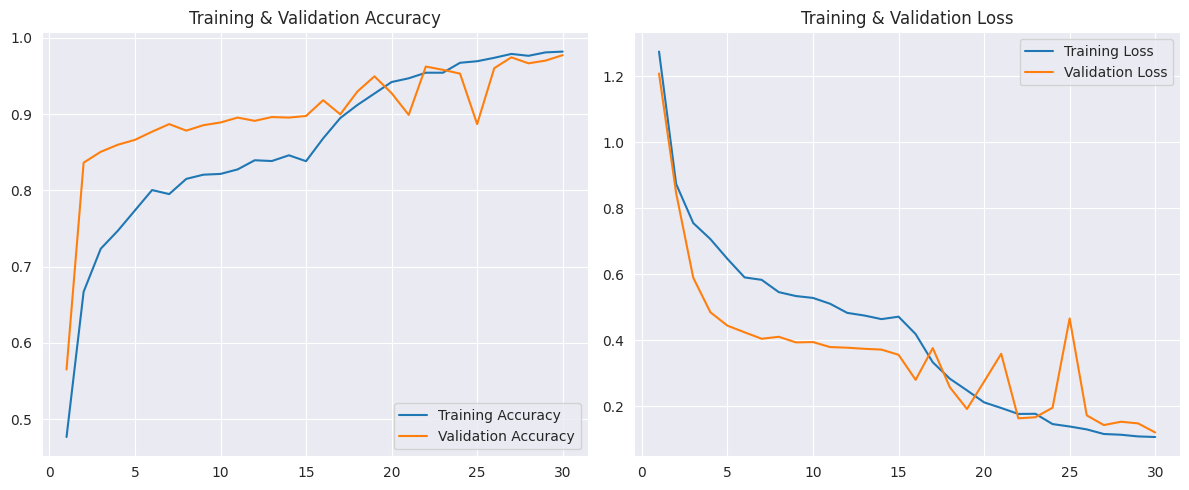

In [17]:
def plot_training(history, history_fine=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if history_fine:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training(history, history_fine)

# Evaluasi Model (Data Uji)


In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/brain_tumor/split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 704 images belonging to 4 classes.


In [19]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.9624 - loss: 0.1641

Test Accuracy: 97.02%
Test Loss: 0.1544


# Menyimpan dan Menampilkan Evaluasi Akurasi & Loss

In [ ]:
results = {
    "Set": ["Training", "Validation", "Testing"],
    "Accuracy": [0.9822, 0.9680, 0.9744],
    "Loss": [0.1165, 0.1427, 0.1359]
}

eval_df = pd.DataFrame(results)
print(eval_df)

          Set  Accuracy    Loss
0    Training    0.9822  0.1165
1  Validation    0.9680  0.1427
2     Testing    0.9744  0.1359


# Confusion Matrix

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step
Class Indices from test_generator: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


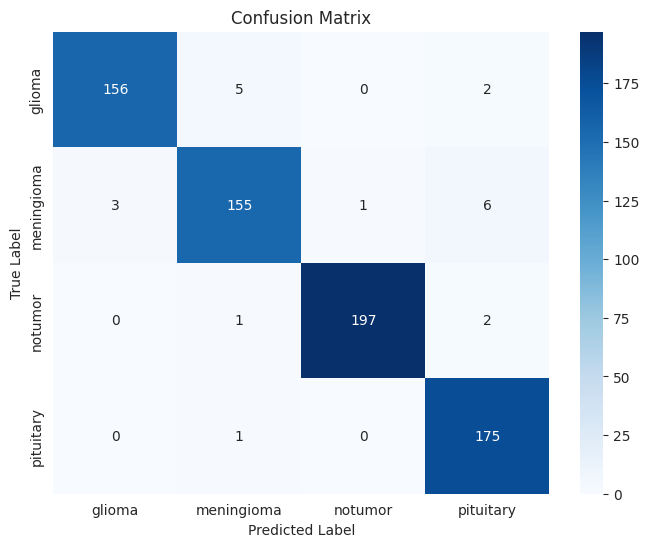

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

y_true = test_generator.classes
y_pred_probabilities = model.predict(test_generator)
y_pred = np.argmax(y_pred_probabilities, axis=1)

class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

print("Class Indices from test_generator:", test_generator.class_indices)

cm = confusion_matrix(y_true, y_pred, labels=list(class_indices.values()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       163
  meningioma       0.96      0.94      0.95       165
     notumor       0.99      0.98      0.99       200
   pituitary       0.95      0.99      0.97       176

    accuracy                           0.97       704
   macro avg       0.97      0.97      0.97       704
weighted avg       0.97      0.97      0.97       704

